In [1]:
import scipy.io
import scipy.spatial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pydmd import MrDMD
from pydmd import DMD
import seaborn as sns

In [291]:
#ecog_data_1 = scipy.io.loadmat('ECoG_Handpose.mat')
#ecog_data_2 = scipy.io.loadmat('011-2015-2.mat')
data_p1 = np.load("../../Pre-Processing/trials/subject_1_session_1_hf40_ica_car.npy")
labels_p1 = np.array([0,1,2, 3]*5)

In [292]:
data = data_p1[0,:,:]

In [276]:
#data = (data - data.mean(axis = 1, keepdims = True))/data.std(axis =1, keepdims = True )

In [277]:
data.shape

(8, 1884)

### Building DMD

In [278]:
first_dmd = DMD(svd_rank= -1 , opt = False)
first_dmd.fit(X=data)

/opt/tljh/user/lib/python3.7/site-packages/pydmd/dmdbase.py:329: UserWarning: Input data matrix X has condition number 6086587302479948.0. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


In [279]:
first_dmd.frequency

array([ 0.5       ,  0.        ,  0.        ,  0.0059091 , -0.0059091 ,
        0.        ,  0.00385534, -0.00385534])

In [ ]:
#second_dmd = DMD(svd_rank= -1 , opt = True)
#second_dmd.fit(X=data_2)

In [ ]:
mm = (abs(first_dmd.modes) - abs(first_dmd.modes).mean())/abs(first_dmd.modes).std()

In [ ]:
sns.heatmap(mm)

In [ ]:
f_dmd_ampl = abs(first_dmd.amplitudes)
#s_dmd_ampl = abs(second_dmd.amplitudes)

In [ ]:
f_dmd_data = first_dmd.reconstructed_data

In [ ]:
#s_dmd_data = second_dmd.reconstructed_data

In [ ]:
f_dmd_data.shape

In [ ]:
plt.plot(f_dmd_data[1,:])

In [ ]:
plt.plot(data[:,1])

In [ ]:
plt.plot(f_dmd_data[:,2] - data[:,2])

In [ ]:
print('The number of eigenvalues is {}'.format(first_dmd.eigs.shape[0]))
first_dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

In [ ]:
t = np.linspace(0, data.shape[0]/256., data.shape[0])

In [ ]:
t.shape

In [ ]:
first_dmd.modes.real.shape

In [ ]:
for dynamic in first_dmd.modes.T:
    print(np.mean(abs(dynamic.real)))
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')

## Augmenting X matrix
ref: B.W.Brunton et al (2016)

In [293]:
data = data_p1[0,:,:]

In [294]:
X_raw = data

In [304]:
def aug_dmd_features(X_raw, h_star = 800):
    #rule of thumb n*h > 2*m
    
    ### Augmentation as in Brunton (2016)
    size_1_X_aug = X_raw.shape[1] - h_star
    if h_star > 1:
        X_aug = np.zeros((X_raw.shape[0],size_1_X_aug))
        for st in range(1,h_star):
            X_aug = np.concatenate((X_aug, X_raw[:,st:-h_star +st]))

        X_aug = X_aug[X_raw.shape[0]:,:]

        X = X_aug[:,:-1]
        Y = X_aug[:,1:]
    else:
        X = X_aug[:,:-1]
        Y = X_aug[:,1:]
    
    #### DMD features extraction
    neuro_dmd = DMD(svd_rank = 0, opt = True #, forward_backward= True, 
                   )#int(0.8*h_star) , opt = True)
    neuro_dmd.fit(X_aug)
    #### DMD eigenvalues
    #real_dmd = neuro_dmd.amplitudes.real
    #imag_dmd = neuro_dmd.amplitudes.imag
    
    #### DMD matrix 
    #matrix_dmd = neuro_dmd.atilde
    
    return neuro_dmd, X_aug

In [305]:
dmd_prova, X_aug = aug_dmd_features(X_raw = data)

/opt/tljh/user/lib/python3.7/site-packages/pydmd/dmdbase.py:329: UserWarning: Input data matrix X has condition number 4.481295862371663e+16. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


In [306]:
X_aug.shape

(6392, 1084)

The number of eigenvalues is 528


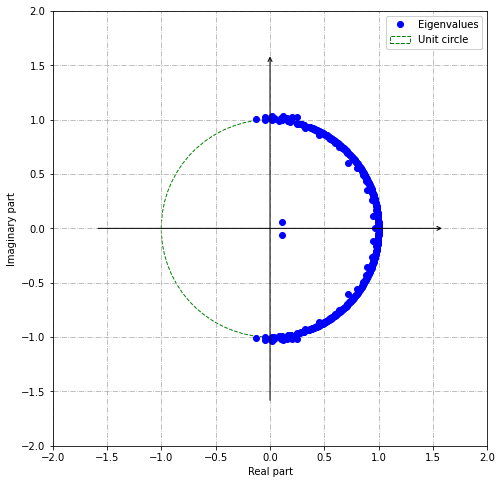

In [307]:
print('The number of eigenvalues is {}'.format(dmd_prova.eigs.shape[0]))
dmd_prova.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

In [308]:
dmd_prova.modes.shape

(6392, 528)

In [309]:
A = np.abs(dmd_prova.modes)
N = dmd_prova.eigs.shape[0]
# Find sorted indices for each row
sorted_row_idx = np.argsort(A, axis=1)[:,A.shape[1]-N::]

# Setup column indexing array
col_idx = np.arange(A.shape[0])[:,None]

# Use the column-row indices to get specific elements from input array. 
# Please note that since the column indexing array isn't of the same shape 
# as the sorted row indices, it will be broadcasted
out = A[col_idx,sorted_row_idx]

In [310]:
#np.linalg.norm(out[:N,::2], axis = 0)**2

In [311]:
#dmd_prova.frequency

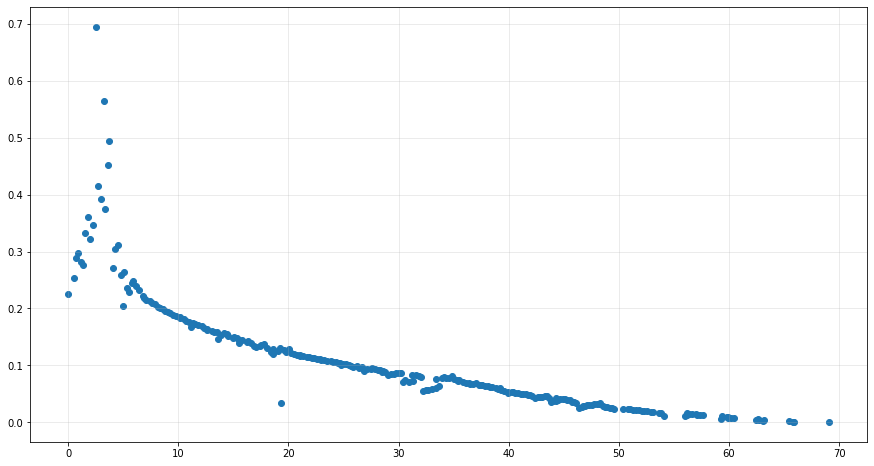

In [312]:
plt.figure(figsize = (15, 8))
#plt.scatter(np.abs(dmd_prova.frequency)*256, np.linalg.norm(dmd_prova.modes[:dmd_prova.eigs.shape[0], :], axis = 0)**2)
plt.scatter(np.abs(dmd_prova.frequency)[::2]*256, np.linalg.norm(out[:N,::2], axis = 0)**2)
plt.grid(alpha = 0.3)
#plt.axvline(x=9)
#plt.axvline(x=18)
#plt.axvline(x=27)
#plt.plot(np.unique(np.abs(dmd_prova.frequency)))
#15, 12, 10, 9 

In [160]:
neuro_data = dmd_prova.reconstructed_data

<AxesSubplot:>

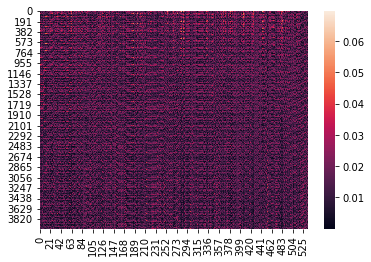

In [161]:
sns.heatmap(np.abs(dmd_prova.modes))

In [162]:
dmd_prova.eigs.shape

(534,)

<AxesSubplot:>

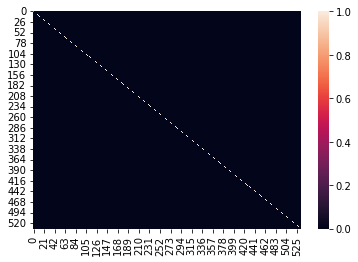

In [163]:
sns.heatmap(np.abs(dmd_prova.eigs*np.eye(dmd_prova.eigs.shape[0])))

In [164]:
#np.real(np.dot(dmd_prova.modes, dmd_prova.dynamics))

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


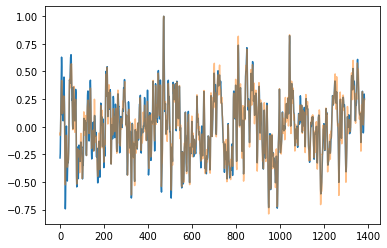

In [165]:
plt.plot(neuro_data[10,:]/neuro_data[10,:].max())
plt.plot(X_aug.T[:,10]/X_aug.T[:,10].max(), alpha = 0.5)

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


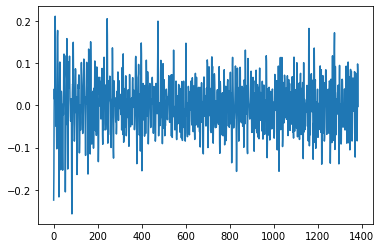

In [166]:
plt.plot(neuro_data[10,:]/neuro_data[10,:].max() - X_aug.T[:,10]/X_aug.T[:,10].max())

In [ ]:
np.linalg.norm(neuro_data, X_aug)